In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
events_data = pd.read_csv(r'C:\Users\79922\Desktop\event_data_train.csv')
submissions_data = pd.read_csv(r'C:\Users\79922\Desktop\submissions_data_train.csv')

In [73]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [74]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [87]:
def time_filter(data, days=2):
    """Фильтруем данные за первые сколько-то дней"""

    # создаем таблицу с первым и последним действием юзера
    min_max_user_time = data.groupby('user_id').agg({'timestamp': 'min'}).rename(
        columns={'timestamp': 'min_timestamp'}).reset_index()

    data_time_filtered = pd.merge(data, min_max_user_time, on='user_id', how='outer')

    # отбираем те записи, которые не позднее какого-то количества дней с начала учебы
    learning_time_threshold = days * 24 * 60 * 60
    data_time_filtered = data_time_filtered.query("timestamp <= min_timestamp + @learning_time_threshold")

    assert data_time_filtered.user_id.nunique() == data.user_id.nunique()

    return data_time_filtered.drop(['min_timestamp'], axis=1)


time_filter(submissions_data).head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
4,31976,1434348123,wrong,15853
5,31976,1434348188,correct,15853
7,31977,1434347371,correct,15853


In [88]:
def base_features(events_data, submissions_data):
    """Создаем датасет с базовыми фичами: действия юзера
    и правильные\неправильные ответы"""

    # таблица с действиями каждого пользователя
    users_events_data = pd.pivot_table(data=events_data, values='step_id',
                                       index='user_id', columns='action',
                                       aggfunc='count', fill_value=0).reset_index().rename_axis('', axis=1)

    # количество правильных и неправильных попыток
    users_scores = pd.pivot_table(data=submissions_data,
                                  values='step_id',
                                  index='user_id',
                                  columns='submission_status',
                                  aggfunc='count',
                                  fill_value=0).reset_index().rename_axis('', axis=1)

    """Создание фичи с долей правильных ответов"""

    users_data = pd.merge(users_scores, users_events_data, on='user_id', how='outer').fillna(0)
    #добавим долю правильных ответов
    users_data['correct_ratio'] = (users_data.correct / (users_data.correct + users_data.wrong)).fillna(0)

    assert users_data.user_id.nunique() == events_data.user_id.nunique()

    return users_data


base_features(events_data, submissions_data).head()

,user_id,correct,wrong,discovered,passed,started_attempt,viewed,correct_ratio
0,2,2.0,0.0,9,9,2,10,1.000000
1,3,29.0,23.0,91,87,30,192,0.557692
2,5,2.0,2.0,11,11,4,12,0.500000
3,8,9.0,21.0,109,84,37,156,0.300000
4,14,0.0,1.0,4,3,1,9,0.000000


In [89]:
def target(submissions_data, threshold=40):
    """Будем считать, что если пользователь не сделал 40 задач, то он не пройдет курс"""

    user_submissions = submissions_data.pivot_table(
        index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0
    ).reset_index().rename_axis('', axis=1)

    # если пользователь не сделал определенное количество задач, то будем считать что он бросил курс
    user_submissions['is_gone'] = (user_submissions.correct < threshold).astype('int')

    return user_submissions.drop(['correct', 'wrong'], axis=1)

In [90]:
def time_features(events_data):
    """Создадим фичу со временем, потраченным на курс"""

    # добавление колонок с датами
    events_data['date'] = pd.to_datetime(events_data['timestamp'], unit='s')
    events_data['day'] = events_data['date'].dt.date

    # создаем таблицу с первым\последним действием юзера и колвом уникальных дней, проведенных на курсе
    users_time_feature = events_data.groupby('user_id').agg({'timestamp': ['min', 'max'], 'day': 'nunique'}).droplevel(
        level=0, axis=1).rename(columns={'nunique': 'days'}).reset_index()

    # добавим, сколько пользователь потратил на курс в часах
    users_time_feature['hours'] = round((users_time_feature['max'] - users_time_feature['min']) / 3600, 1)

    return users_time_feature.drop(['max', 'min', 'days'], axis=1)


time_features(events_data).head()

,user_id,hours
0,1,0.0
1,2,1345.4
2,3,2839.8
3,5,9362.0
4,7,0.0


In [91]:
def steps_tried(submissions_data):
    """Создание фичи, сколько пользователь попытался сделать шагов """

    steps_tried = submissions_data.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(
        columns={'step_id': 'steps_tried'})

    return steps_tried

In [92]:
def create_df(events_data, submissions_data):
    """Формируем датасеты X и y"""

    # фильтруем данные по дням от начала учебы
    events_2days = time_filter(events_data)
    submissions_2days = time_filter(submissions_data)

    # создаем таблицу с базовыми фичами
    users_data = base_features(events_2days, submissions_2days)

    # создаем целевую переменную
    users_target_feature = target(submissions_data, threshold=40)

    # создаем таблицу с временными фичами
    users_time_feature = time_features(events_2days)

    # создаем фичи с попытками степов
    users_steps_tried = steps_tried(submissions_2days)

    # соединяем шаги
    first_merge = users_data.merge(users_steps_tried, how='outer').fillna(0)

    # соединяем фичи со временем
    second_merge = first_merge.merge(users_time_feature, how='outer')

    # присоединяем целевую переменную
    third_merge = second_merge.merge(users_target_feature, how='outer').fillna(0).set_index('user_id')

    # отделяем целевую переменную и удаляем ее из основного датасета
    y = third_merge['is_gone'].map(int)
    X = third_merge.drop(['is_gone'], axis=1)

    return X, y


In [93]:
X, y = create_df(events_data, submissions_data)

In [94]:
def correlation(data):
    """Строим матрицу корреляций"""
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(), annot=True)
    plt.show()


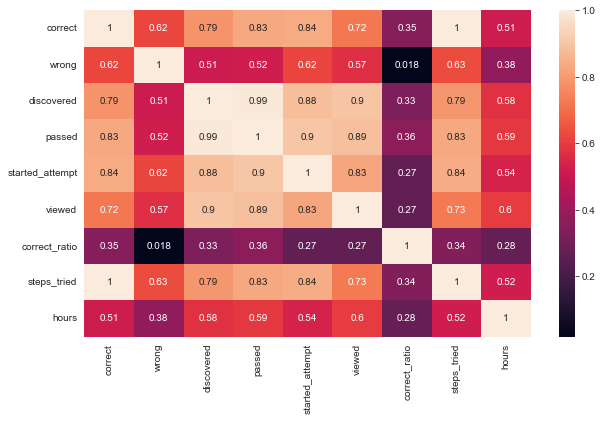

In [95]:
correlation(X)

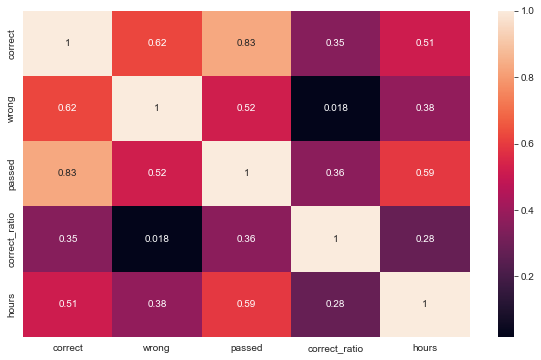

In [96]:
# Удалим сильно коррелирующие признаки
X = X.drop(columns=['steps_tried', 'discovered', 'viewed', 'started_attempt'])
correlation(X)

In [97]:
X.head()

,correct,wrong,passed,correct_ratio,hours
user_id,,,,,
2,2.0,0.0,9,1.0,0.1
3,4.0,4.0,15,0.5,0.3
5,2.0,2.0,1,0.5,0.0
8,9.0,21.0,84,0.3,0.2
14,0.0,1.0,3,0.0,0.7


In [85]:
X.to_csv('data/X.csv')
y.to_csv('data/y.csv')